In [2]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
working_dir = os.getcwd()
working_dir

In [ ]:
os.chdir(os.path.dirname(working_dir))
os.getcwd()

In [20]:
transform = transforms.ToTensor()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

data_loader = DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [21]:
print(mnist_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [22]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(f"[INFO] Minimum data value: {torch.min(images)}, Maximum data value: {torch.max(images)}")

[INFO] Minimum data value: 0.0, Maximum data value: 1.0


In [23]:
class Autoencoder_Linear(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N, 784 (Batch size, 28*28)
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=128), # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # N, 3
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), # N, 3 -> N, 784
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784), # N, 784
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note: Data min,max [-1, 1] -> Tanh activation function

In [27]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # N, 64, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid(), 
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note: Data min,max [-1, 1] -> Tanh activation function
# nn.MaxPool2d -> nn.MaxUnpool2d

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Current running device: {device}")

[INFO] Current running device: cuda


In [69]:
# model = Autoencoder_Linear()
model = Autoencoder()

In [70]:
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [71]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        if model._get_name().split("_")[-1] == "Linear" : img = img.reshape(-1, 28*28)
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"[INFO] Epoch: {epoch+1}, Loss: {loss.item():.4f}")
    outputs.append((epoch, img, recon))


[INFO] Epoch: 1, Loss: 0.0107
[INFO] Epoch: 2, Loss: 0.0068
[INFO] Epoch: 3, Loss: 0.0053
[INFO] Epoch: 4, Loss: 0.0035
[INFO] Epoch: 5, Loss: 0.0033
[INFO] Epoch: 6, Loss: 0.0034
[INFO] Epoch: 7, Loss: 0.0032
[INFO] Epoch: 8, Loss: 0.0030
[INFO] Epoch: 9, Loss: 0.0032
[INFO] Epoch: 10, Loss: 0.0023


In [68]:
def plot_results(outputs, type_lin:bool=True, num_exp:int=9):
    for epoch in range(0, num_epochs, 4):
        plt.figure(figsize=(num_exp,2))
        plt.gray()
        imgs = outputs[epoch][1].cpu().detach().numpy()
        recons = outputs[epoch][2].cpu().detach().numpy()
        for i, (img, recon) in enumerate(zip(imgs, recons)):
            if i >= num_exp: break
            plt.subplot(2, num_exp, i+1)
            if type_lin : img = img.reshape(-1, 28, 28)
            plt.axis("off")
            plt.imshow(img[0])

            plt.subplot(2, num_exp, num_exp+i+1)
            if type_lin : recon = recon.reshape(-1, 28, 28)
            plt.axis("off")
            plt.imshow(recon[0])

## Linear Model

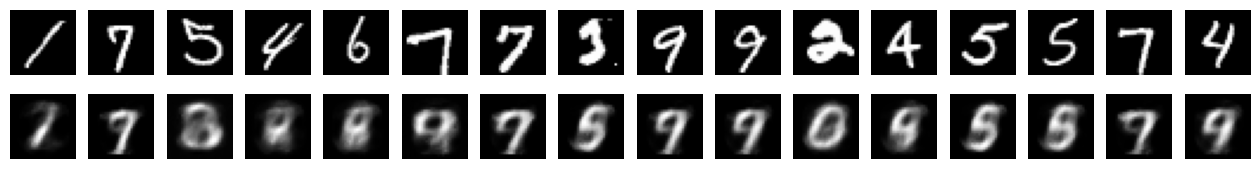

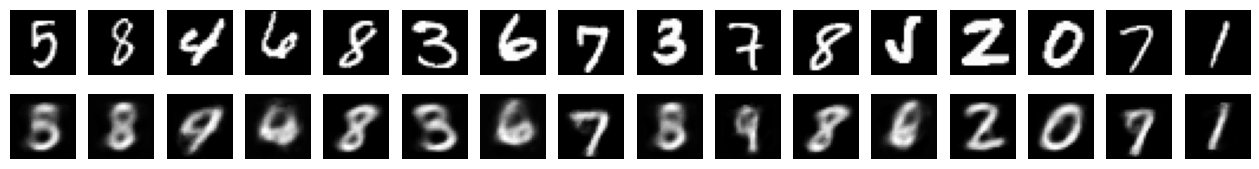

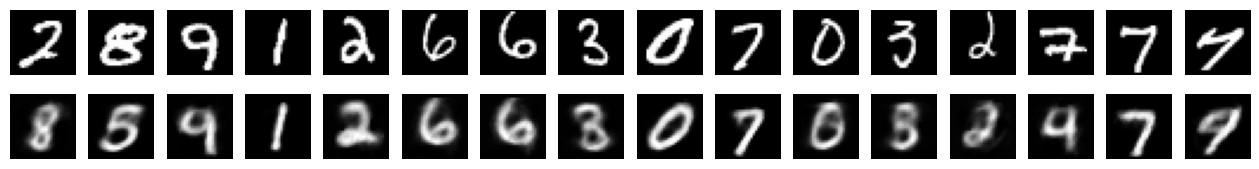

In [67]:
plot_results(outputs, type_lin=True, num_exp=16)

## CNN Model

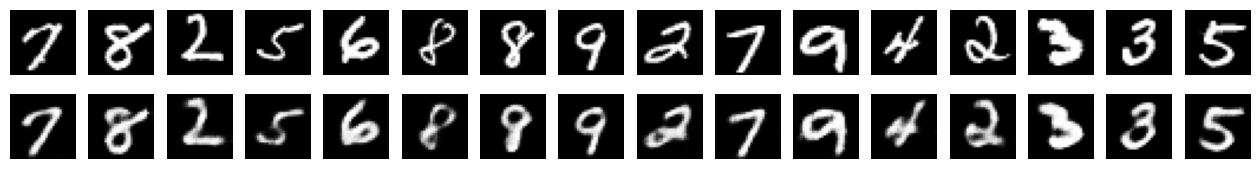

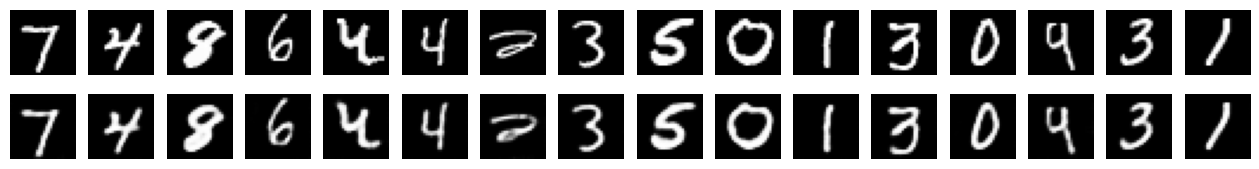

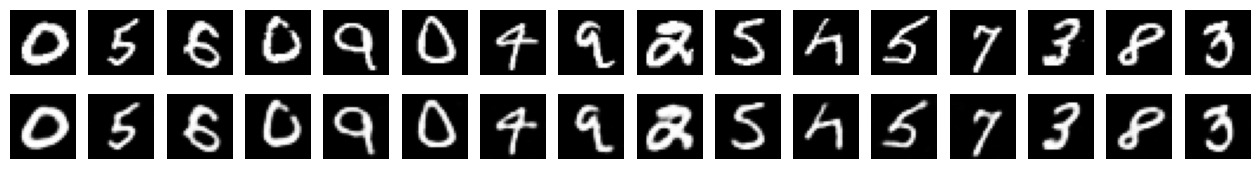

In [72]:
plot_results(outputs, type_lin=False, num_exp=16)